In [9]:
#%matplotlib inline     
# ^Sans animations
%matplotlib notebook 
# ^Avec animations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

#### Changement de format pour les jours de la semaine

In [10]:
def conversion1_jour(jour):
    ''' str * dict -> int
        Conversion : str -> int pour les jours de la semaine '''
    Jour1 = {'lundi':0,'mardi':1,'mercredi':2,'jeudi':3,'vendredi':4,'samedi':5,'dimanche':6}
    return (Jour1[jour])

In [11]:
conversion1_jour("mardi")

1

### Amélioration Modèle 3 : Nous étudions l'evolution du remplissage de la bibliothèque pendant une semaine de Juillet en fonction du temps  

Nous disposons du nombre de place et des horaires d'ouverture de la bibliothèque 

In [12]:
# Exemple : horaire pour la BDL durant une semaine de Juillet
horaire = [(0,0) , (9,19) , (9,19) , (9,19) , (9,19) , (0,0) , (0,0)]

def est_ouvert(heure,jour,horaire):
    '''float * str * dict[tuple] -> bool
    indique si la bibliotheque est ouverte ou fermée en fonction de l'heure actuelle 'heure', 
    du jour de la semaine 'jour' et des horaires d'ouverture 'horaire'  '''
    j = conversion1_jour(jour)
    date = horaire[j]
    if date!= (0,0):
        ouverture = date[0]
        fermeture = date[1]
        return ouverture <= heure < fermeture
    return False

In [13]:
# Exemple : On teste si la bibliothèque est ouverte le lundi à 11h.
print( est_ouvert(11,'lundi',horaire) )

False


***Nous avons collecté les affluences de la bibliothèque des licences pour une semaine de Juillet.
Avec notre modèle, nous allons essayer de retrouver ces données.***

In [14]:
#affluence selon l'heure et le jour. Toutes les listes ont le même nombre d'éléments.
#On comble les trous s'il y en a.(samedi)

semaine = {'lundi' : [0.17, 0.33, 0.42, 0.5, 0.58, 0.58, 0.67, 0.75, 0.83, 0.92, 0.75, 0.5, 0.25] , 
 'mardi' : [0.08, 0.17, 0.25, 0.33, 0.42, 0.42, 0.42, 0.5, 0.58, 0.58, 0.5, 0.33, 0.17] , 
 'mercredi' : [0.17, 0.33, 0.42, 0.5, 0.5, 0.5, 0.58, 0.58, 0.58, 0.5, 0.33, 0.25, 0.08] ,
 'jeudi' : [0.08, 0.17, 0.25, 0.33, 0.5, 0.58, 0.5, 0.5, 0.67, 0.75, 0.67, 0.42, 0.17] , 
 'vendredi' : [0.08, 0.25, 0.5, 0.58, 0.67, 0.83, 0.83, 0.67, 0.67, 0.67, 0.67, 0.42, 0.17] , 
 'samedi' : [0,0.25, 0.75, 0.58, 0.75, 0.92, 0.83, 0.83, 1.0, 0.75, 0.25,0,0] }

### Nouvelle modélisation en tenant compte du paramètre horaire.


De plus, nous introduirons trois nouvelles fonctions : **nb_entre, nb_sortie et aff_actu.**


Nous allons améliorer notre modèle en découpant une journée en plusieurs phases  : 

**'bigenter' **: période d'importante entrée 

**'bigexit' **: période d'importante sortie 

**'bigstay'** : période avec flux (entrée et/ou sortie) très faible 

**'unknown'** : période de flux inconnu (ce sont les heures qui restent)

NB : Les phases peuvent être cumulées (attention aux incompatibilités!)


In [15]:
# On suppose que phase est valide
# L'union de tous les intervalles doit correspondre aux ouvertures de la bibliothèque
# Les intervalles sont disjoints, de la forme ']debut,fin]'

phase = {'bigenter': [(10,11) , (14,17)] ,  # (arrivée) , (fermeture de la bibliothèque)
         'bigexit' : [(12,13) , (18,19)]  , # (déjeuner), (retour chez soi)
         'bigstay':  [(9,10) , (11,12) ] , # (arrivée) , (période de travail) 
         'unknown':  [(13,14),(17,18)]  } 

In [16]:
def decoupage(phase,heure):
    ''' dict * float -> str
        retourne la phase correspondante à l'heure
        hyp : est_ouvert(heure...) == True '''
    for cle in phase:
        for couple in phase[cle]:
            debut=couple[0] 
            fin=couple[1]
            if debut <= heure < fin:
                return cle
    return 'error'

In [17]:
#Voici un test pour vérifier la fonction découpage, elle ne doit pas retourner 'error' aux horaires d'ouverture

for i in range(24):
        print( decoupage(phase,i) ,i )
        
#On retourne 'error' aux horaires de fermeture

error 0
error 1
error 2
error 3
error 4
error 5
error 6
error 7
error 8
bigstay 9
bigenter 10
bigstay 11
bigexit 12
unknown 13
bigenter 14
bigenter 15
bigenter 16
unknown 17
bigexit 18
error 19
error 20
error 21
error 22
error 23


In [18]:
#emax : nombre de place restant
# bt : nombre de personne dans la bibliothèque à l'instant t
#nb: nombre d'entree/sortie

def correction(nb,bt,emax):
    '''retourne le nombre d'entrée réalisable.'''
    if nb >= 0:
        if nb > emax:
            nb = emax
    else:
        if -nb > bt: #le signe '-' correspond à la valeur absolue
            nb = -bt    
    return nb

### Nous allons tester correction(nb,bt,emax)

In [19]:
# Nous avons 500 personnes dans la bibliothèque et il reste 10 places libres.
# Nous essayons de faire entrer 500 personnes, mais ce n'est pas possible.

print(correction(500,500,10))

10


In [20]:
#Nous pouvons faire sortir au maximumle nombre de personne qu'il y a dans la bibliothèque

print(correction(-551,400,10))

-400


*** Si nb_flux est positif, il est compté en entrée, sinon en sortie ***

***exemple:***

**'bigenter'** : nbtir 100

**'bigexit'** : -100

**'bigstay'** : -10 à 10

**'unknown'** : -100 à 100


In [21]:
def signe(nombre):
    ''' Nombre -> Nombre
        retourne 1 si Nombre est positif, sinon -1'''
    if nombre < 0:
        return -1
    return 1

In [22]:
# testons la fonction signe(nombre)

print( signe(5) )
print( signe(-5) )
print( signe(0) )

1
-1
1


In [23]:
def alea_signe():
    ''' None -> int
        retourne aléatoirement 0 ou 1'''
    u = np.random.random() # u est un nombre aléatoire entre 0 et 1
    if u < 0.5: 
        return -1
    return 1

In [24]:
# test de alea_signe()

c1,c2 = 0,0
for loop in range(1000):
    a=alea_signe()
    if a==1:
        c1+=1
    else:
        c2+=1
print(c1/1000)
print(c2/1000)

0.497
0.503


In [25]:
def alea_flux(aff):
    '''
    float->int
    en fonction du taux d'affluence et d'une probabilité ,retourne 1 si l'élève rentre, sinon 0.
    '''
    u = np.random.random() # u est un nombre aléatoire entre 0 et 1
    if u < 0.5: 
        return 0
    return 1

### Ce programme est identique à alea_signe()

In [26]:
# s: nombre de personnes qui entrent ou qui sortent de al bibliothèque

def nb_flux(aff,Nom_phase,btmax):
    '''float * int * str * int -> int
       retourne le nombre de flux'''  
    
    # Attention ! : 'bigstay' et 'unknown' sont en valeurs absolues
    #Flux est un dictionnaire de proportion en fonction des phases
    Flux = {"bigenter": 1/2,'bigexit' : -1/6, 'bigstay' : 1/70, 'unknown' : 1/4}
    
    nbtir=round(Flux[Nom_phase]*btmax)
    s=0
    for i in range(abs(nbtir)):
        s += alea_flux(aff)
    s*= signe(nbtir)
    
    if Nom_phase == 'bigstay' or Nom_phase == 'unknown':
        s*=alea_signe()
    return s

In [27]:
# Voici un test de la fonction nb_flux(aff,Nom_phase,btmax) :

nb_flux(0.5,"unknown",1000)

-125

***Dans bibliothèquetemp2, nous avons supprimé les paramètres afflim, p1 et p2 pour simplifier nos fonctions. ***

*En d'autres termes, nous ne tiendrons plus compte de l'hésitation des étudiants.*

In [29]:
# Bibliothèquetemp2 permet  en fonction des horaires d'ouverture de la bibliothèque
# et de l'heure de la journée de faire des entrée/sortie multiple.

#bt0: nombre initial de personne dans la bibliothèque. 
# bt : nombre de personne dans la bibliothèque à l'instant t
#btmax: nombre de places de la bibliothèque.
# aff : le taux d'affluence actuelle
# afflim : le taux d'affluence à partir duquel la personne hésite
# emax : nombre place restant
# nb : nombre d'entree/sortie
# On fera un cycle de 24h

# Exemple : horaire pour la BDL durant une semaine de Juillet
horaire = [(0,0) , (9,19) , (9,19) , (9,19) , (9,19) , (0,0) , (0,0)]

# On suppose que phase est valide.

#découpage de la journée en plusieurs phases
phase = {'bigenter': [(10,11) , (14,17)] ,  # (arrivée) , (fermeture de la bibliothèque)
         'bigexit' : [(12,13) , (18,19)]  , # (déjeuner), (retour chez soi)
         'bigstay':  [(9,10) , (11,12) ] , # (arrivée) , (période de travail) 
         'unknown':  [(13,14),(17,18)]  } 


def bibliothèquetemp2(bt0,btmax,jour):
                    #(int,int,str)
    ''' hyp : 0 <= bt <= btmax
        retourne la liste des affluences pour toutes les heures de la journée'''
    bt=bt0
    aff=bt/btmax
    L=[bt0]
    for t in range(24):
        if est_ouvert(t,jour,horaire):
            Nom_phase = decoupage(phase,t)
            emax = btmax-bt
            nb=nb_flux(aff,Nom_phase,btmax)
            nb=correction(nb,bt,emax)
            bt+=nb
        else:
            bt=0
            
        L.append(bt)
        aff=bt/btmax
    return L

In [30]:
print(bibliothèquetemp2(0,745,"lundi"))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**'bigenter' **: période d'importante entrée 

**'bigexit' **: période d'importante sortie 

**'bigstay'** : période avec flux (entrée et/ou sortie) très faible 

**'unknown'** : période de flux inconnu (ce sont les heures qui restent)

 

<IPython.core.display.Javascript object>


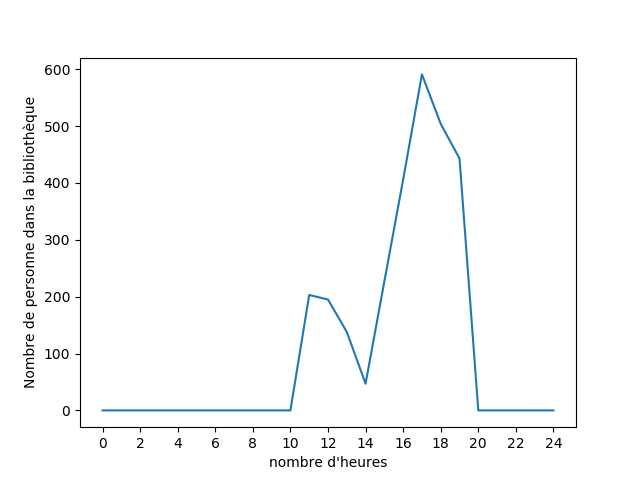

In [32]:
def plotb2(L):
    plt.figure()
    plt.plot(L)
    plt.ylabel("Nombre de personne dans la bibliothèque")
    plt.xlabel("nombre d'heures")
    plt.xticks([i for i in range(0,25,2)])
    plt.show()
    return 
plotb2(bibliothèquetemp2(0,745,"mardi"))

phase 1 : un **big stay** avant 10h.

phase 2 : un **bigenter** entre 10h et 11h.

phase 3 : un **bigstay** entre 11h et 12h.

phase 4 : :un **bigexit** entre 12h et 14h.

phase 5 : un **bigenter** entre 14h et 17h.

phase 6 : un **bigexit** entre 17h et 19h.

Les phases décrite ci-dessus sont représentatives de la plupart des jours.

*** Nous n'avons pas pu discerner la phase "unknown" en observant la tendance de la courbe ***

